# 蔬菜价格预测模型

2018年4月25日

在这个项目中，我们将使用成都市蔬菜价格数据建立一个有关最高价和最低价的预测模型。探索多个常用的监督学习算法并找出其中最优的方案。

## 1. 数据准备

### 1.1 导入数据

首先从CSV文件中导入数据，计算每一条数据前3天和前9天价格平均值，然后将数据拆分为特征和目标两个部分。

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [41]:
data = pd.read_csv('./vegetable_prices.csv')

# calculating average prices 3 or 9 days before
data['h_3'] = data['h_price'].shift(1).rolling(window=3).mean()
data['h_9'] = data['h_price'].shift(1).rolling(window=9).mean()
data['l_3'] = data['l_price'].shift(1).rolling(window=3).mean()
data['l_9'] = data['l_price'].shift(1).rolling(window=9).mean()
data = data.dropna()

prices = data[['h_price', 'l_price']]
features = data.drop(['l_price', 'h_price', 'v_price'], axis=1)

print('chengdu vegetable dataset has {} data points with {} variables each'.format(*data.shape))

chengdu vegetable dataset has 7371 data points with 22 variables each


### 1.2 分析数据

数据包含如下22个变量：

In [42]:
data.head()

,v_name,v_price,h_price,l_price,v_market,area,source,updateTime,insertTime,yWendu,...,fengli,fengxiang,aqi,aqiLevel,aqiInfo,cpi,h_3,h_9,l_3,l_9
9,生姜,7.2,8.0,6.6,四川成都龙泉聚和(国际)果蔬菜交易中心,cd,vegnet.com.cn,2016-03-01,2018-04-19,6,...,微风,南风,137,3,轻度污染,102.3,3.666667,3.377778,2.900000,2.666667
10,大蒜,8.4,8.8,7.8,四川成都龙泉聚和(国际)果蔬菜交易中心,cd,vegnet.com.cn,2016-03-01,2018-04-19,6,...,微风,南风,137,3,轻度污染,102.3,5.600000,4.066667,4.533333,3.266667
11,芹菜,4.8,5.2,4.5,四川成都龙泉聚和(国际)果蔬菜交易中心,cd,vegnet.com.cn,2016-03-01,2018-04-19,6,...,微风,南风,137,3,轻度污染,102.3,7.600000,4.855556,6.466667,4.000000
12,莴笋,2.4,3.0,2.1,四川成都龙泉聚和(国际)果蔬菜交易中心,cd,vegnet.com.cn,2016-03-01,2018-04-19,6,...,微风,南风,137,3,轻度污染,102.3,7.333333,4.833333,6.300000,4.033333
13,蒜薹,9.5,10.0,8.0,四川成都龙泉聚和(国际)果蔬菜交易中心,cd,vegnet.com.cn,2016-03-01,2018-04-19,6,...,微风,南风,137,3,轻度污染,102.3,5.666667,4.555556,4.800000,3.733333


In [43]:
data.describe()

,v_price,h_price,l_price,yWendu,bWendu,aqi,aqiLevel,cpi,h_3,h_9,l_3,l_9
count,7371.000000,7371.000000,7371.000000,7371.000000,7371.000000,7371.000000,7371.000000,7371.000000,7371.000000,7371.000000,7371.000000,7371.000000
mean,4.278974,4.882214,3.843664,12.125085,19.888211,90.249084,2.277574,101.695387,4.881142,4.880273,3.843135,3.842783
std,2.945466,3.311870,2.756567,7.613284,7.914107,47.855732,0.961405,0.563581,1.998666,1.037054,1.626428,0.746328
min,0.800000,0.900000,0.700000,-4.000000,4.000000,25.000000,1.000000,100.800000,1.166667,2.100000,0.900000,1.666667
25%,2.000000,2.300000,1.800000,6.000000,13.000000,54.000000,2.000000,101.300000,3.333333,4.277778,2.533333,3.422222
50%,3.600000,4.000000,3.200000,12.000000,19.000000,79.000000,2.000000,101.400000,4.500000,4.800000,3.533333,3.888889
75%,5.000000,6.000000,4.500000,19.000000,27.000000,117.000000,3.000000,102.300000,6.133333,5.511111,4.700000,4.300000
max,16.500000,20.000000,16.000000,26.000000,36.000000,318.000000,6.000000,102.600000,12.333333,9.700000,8.366667,6.811111


以上是对原始数据集中的几个数值型变量进行的基本统计分析，可以看到均值，标准差，中位数和最值等基本描述统计量。

### 1.3 数据分割与重排
接下来，先将数据集中的蔬菜名称转换为独热编码（One Hot Encoding），然后分成训练和测试两个子集并打乱数据顺序，消除数据集中由于顺序产生的偏差，分割比例为80%数据用于训练，20%用于测试。

In [44]:
from sklearn.model_selection import train_test_split
from pandas import get_dummies

features_encoded = get_dummies(features, columns=['v_name'])
X_train, X_test, y_train, y_test = train_test_split(features_encoded, prices, test_size=0.2, random_state=42)

print('dataset train: {} {}, test: {} {}'.format(
    X_train.shape, y_train.shape, X_test.shape, y_test.shape))

dataset train: (5896, 41) (5896, 2), test: (1475, 41) (1475, 2)


独热编码后，变量增加到了41个，其中蔬菜名称变成了一系列数值型数据。

## 2. 训练模型

### 2.1 方案1：线性回归模型

根据前面对数据进行的探索性分析，我们得到如下结论：

1. 蔬菜最高价与“最低价”、“白天温度”、“夜晚温度”、“前3天最高价均值”、“前9天最高价均值”、“前3天最低价均值”、“前9天最低价均值”具有相关关系；
2. 蔬菜最低价与“最高价”、“前3天最高价均值”、“前9天最高价均值”、“前3天最低价均值”、“前9天最低价均值”具有相关关系；

因此首先想到的是通过多元线性回归建立预测模型。首先需要在分割好的数据集中删掉不相关的变量，计算需要的变量。

In [49]:
def linear_regression_preprocess(data, drops):
    processed = data.drop(drops, axis=1)
    return processed

X_train_lm = linear_regression_preprocess(X_train, [
    'v_market', 
    'area',
    'source', 
    'updateTime', 
    'insertTime', 
    'tianqi', 
    'fengli', 
    'fengxiang', 
    'aqi', 
    'aqiInfo', 
    'aqiLevel', 
    'cpi'
])

X_test_lm = linear_regression_preprocess(X_test, [
    'v_market', 
    'area',
    'source', 
    'updateTime', 
    'insertTime', 
    'tianqi', 
    'fengli', 
    'fengxiang', 
    'aqi', 
    'aqiInfo', 
    'aqiLevel', 
    'cpi',
])

X_train_lm.head()

,yWendu,bWendu,h_3,h_9,l_3,l_9,v_name_冬瓜,v_name_南瓜,v_name_土豆,v_name_大白菜,...,v_name_茄子,v_name_莴笋,v_name_葱头,v_name_蒜薹,v_name_西红柿,v_name_金针菇,v_name_青椒,v_name_韭菜,v_name_香菇,v_name_黄瓜
6241,0,12,3.666667,4.611111,2.166667,2.600000,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2532,14,23,2.333333,2.866667,1.933333,2.400000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5247,14,20,4.766667,5.988889,3.600000,4.288889,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5727,8,13,4.166667,5.355556,3.200000,4.177778,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3299,8,13,2.100000,3.800000,1.700000,3.088889,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


下面将使用网格搜索和K折交叉验证的方法，基于线性回归模型建立对价格的预测。

In [54]:
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

def performance_metric(y_true, y_pred):
    score = r2_score(y_true, y_pred)
    return score

def fit_model(X, y):
    cross_validator = KFold(n_splits=5, shuffle=True, random_state=42)
    regressor = LinearRegression()
    params = {
        'fit_intercept': [True, False],
        'normalize': [True, False],
    }
    scoring_func = make_scorer(performance_metric)
    grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_func, cv=cross_validator)
    grid = grid.fit(X, y)
    return grid.best_estimator_

optimal_regressor = fit_model(X_train_lm, y_train)

print('paramter for the optimal model {}'.format(optimal_regressor.get_params()))

paramter for the optimal model {'copy_X': True, 'normalize': False, 'n_jobs': 1, 'fit_intercept': True}


In [55]:
y_pred = optimal_regressor.predict(X_test_lm)
r2 = performance_metric(y_test, y_pred)

print('optimal model has R^2 score {:,.2f} on test data'.format(r2))

optimal model has R^2 score 0.88 on test data


In [56]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

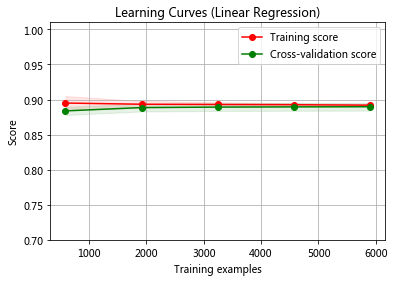

In [59]:
import sys  

reload(sys)  
sys.setdefaultencoding('utf8')

title = 'Learning Curves (Linear Regression)'
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
X = features_encoded.drop([
    'v_market', 
    'area',
    'source', 
    'updateTime', 
    'insertTime', 
    'tianqi', 
    'fengli', 
    'fengxiang', 
    'aqi', 
    'aqiInfo', 
    'aqiLevel', 
    'cpi'
], axis=1)
y = prices

plot_learning_curve(optimal_regressor, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

## 3. 结论